In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from db import get_db_connection

In [2]:
conn = get_db_connection()
query = 'SELECT * FROM lb_comments;'
df = pd.read_sql(query,conn)
conn.close()

C:\Users\marci\AppData\Local\Temp\ipykernel_7604\2065160649.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn)


In [3]:
df['label'] = df['classification'].map({'BOM' : 2, 'NEUTRO' : 1, 'RUIM' : 0})

In [4]:
df['comment_text'] = df['comment_text'].str.lower()

In [5]:
df = df[['comment_text', 'label']]

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'], df['label'], test_size=0.2, random_state=42)

### Testes com 3 modelos de classificação

In [8]:
models = {
    'LogisticRegression': (LogisticRegression(), {
        'logisticregression__C': [0.01, 0.1, 1, 10],
        'logisticregression__solver': ['liblinear'],
        'logisticregression__dual' : [False, True],
        'logisticregression__random_state' : [42],
    }),
    'RandomForestClassifier': (RandomForestClassifier(), {
        'randomforestclassifier__n_estimators': [25, 50, 100, 200, 225, 230, 250, 275, 300],
        'randomforestclassifier__max_depth': [None,5 , 10, 20, 25, 30],
        'randomforestclassifier__min_samples_split' : [2, 10, 20, 50, 100],
        'randomforestclassifier__min_samples_leaf' : [2, 10, 20, 50, 100],
        'randomforestclassifier__random_state' : [42],
    }),
    'SVC': (SVC(), {
        'svc__C': [0.1, 1, 10, 15, 20, 25],
        'svc__kernel': ['linear', 'rbf'],
        'svc__probability' : [True, False],
        'svc__gamma' : ['scale'],
        'svc__random_state' : [42] , 
    })
}
results = {}

---- LogisticRegression ----
              precision    recall  f1-score   support

           0       0.62      0.70      0.66        40
           1       0.68      0.65      0.66        62
           2       0.67      0.65      0.66        48

    accuracy                           0.66       150
   macro avg       0.66      0.66      0.66       150
weighted avg       0.66      0.66      0.66       150

Melhores parâmetros: {'logisticregression__C': 1, 'logisticregression__dual': False, 'logisticregression__random_state': 42, 'logisticregression__solver': 'liblinear'}
Melhor acurácia: 0.7395658263305322



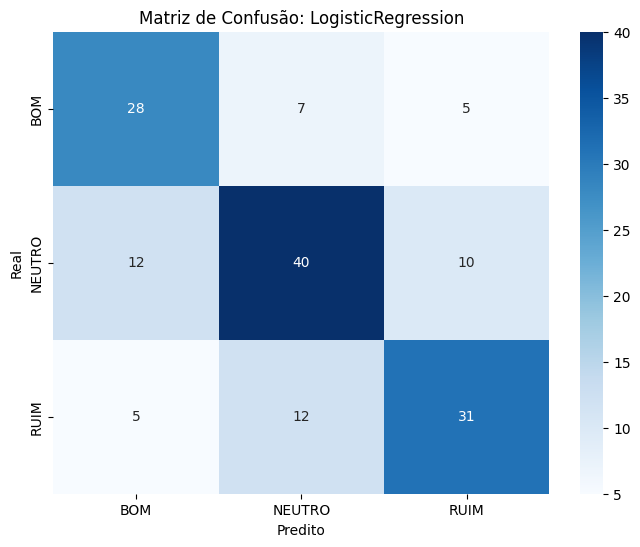

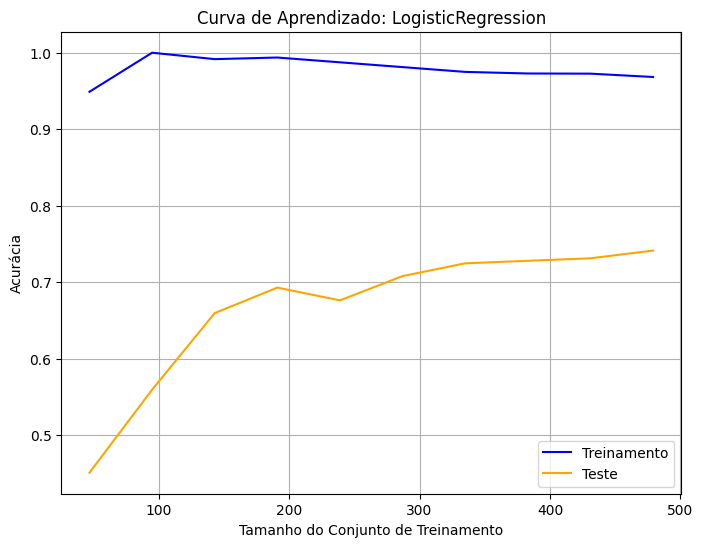

In [9]:
for model_name, (model, params) in models.items():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        (model_name.lower(), model)
    ])
    
    grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='accuracy')
    
    grid_search.fit(X_train, y_train)
    
    results[model_name] = grid_search
    
    #------------------CLASSIFICATION REPORT
    y_pred = grid_search.predict(X_test)
    print(f'---- {model_name} ----')
    print(classification_report(y_test, y_pred))
    print(f'Melhores parâmetros: {grid_search.best_params_}')
    print(f'Melhor acurácia: {grid_search.best_score_}\n')
    
    #-------------------MATRIZ DE CONFUSÃO
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BOM', 'NEUTRO', 'RUIM'], yticklabels=['BOM', 'NEUTRO', 'RUIM'])
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.title(f'Matriz de Confusão: {model_name}')
    plt.show()
            
    #--------------------CURVA DE APRENDIZAGEM
    train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, 
                                                            cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, label='Treinamento', color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Teste', color='orange')
    plt.title(f'Curva de Aprendizado: {model_name}')
    plt.xlabel('Tamanho do Conjunto de Treinamento')
    plt.ylabel('Acurácia')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    